In [1]:
import pandas as pd
import json as js
from collections import Counter
import seaborn as sns
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import random
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, accuracy_score
from scipy.spatial.distance import cosine
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest, mutual_info_regression, chi2
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Utils

In [2]:
def save_df(df, name, path=''):
    df.to_csv(path+'/'+name, sep='\t', index=False)

In [3]:
def load_df(name, path=''):
    return pd.read_csv(path+'/'+name, sep='\t', index_col=False)

In [4]:
def KL_oneside(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [5]:
def KL(a, b):
    return 0.5*KL_oneside(a, b) + 0.5*KL_oneside(b, a)

In [6]:
def flatten(array, n):
    temp = []
    for ii in range(n+1):
        temp.extend(array[ii])
    return temp

In [7]:
def flatten_name(df, n):
    temp = []
    for ii in range(n+1):
        temp.extend(df[ii]['name'])
    return temp

In [8]:
def concat_train_test(array1, array2):
    return flatten(array1, len(array1)-1) + array2[0]

# Read Data

In [9]:
info = []
with open('modified_data/dblp-ref-0-trans.json', 'r') as fin:
    s = fin.readlines()
for ii in s:
    info.append(js.loads(ii[:-1]))
# with open('data/dblp-ref/dblp-ref-1.json', 'r') as fin:
#     s = fin.readlines()
# for ii in s:
#     info.append(js.loads(ii[:-1]))
# with open('data/dblp-ref/dblp-ref-2.json', 'r') as fin:
#     s = fin.readlines()
# for ii in s:
#     info.append(js.loads(ii[:-1]))
# with open('data/dblp-ref/dblp-ref-3.json', 'r') as fin:
#     s = fin.readlines()
# for ii in s:
#     info.append(js.loads(ii[:-1]))

In [10]:
info[0]

{'abstract': 'purpose study develop learning tool high school students studying scientific aspects information communication net works specifically focus basic principles network proto cols aim develop learning tool tool gives students hands experience help understand basic principles network protocols',
 'authors': ['Makoto Satoh',
  'Ryo Muramatsu',
  'Mizue Kayama',
  'Kazunori Itoh',
  'Masami Hashimoto',
  'Makoto Otani',
  'Michio Shimizu',
  'Masahiko Sugimoto'],
 'n_citation': 0,
 'references': ['51c7e02e-f5ed-431a-8cf5-f761f266d4be',
  '69b625b9-ebc5-4b60-b385-8a07945f5de9'],
 'title': 'Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map',
 'venue': 'international conference on human-computer interaction',
 'year': 2013,
 'id': '00127ee2-cb05-48ce-bc49-9de556b93346'}

# Extract Input and Label

In [11]:
def get_authors(info, threshold):
    ans = Counter()
    for ii in info:
        ans.update([jj for jj in ii['authors'] if '.' not in jj])
    return Counter([ii for ii in ans.elements() if ans[ii] > threshold])

In [12]:
author_list = get_authors(info, 5)

In [13]:
def get_input_and_label(author_list, info):
    dic = {}
    for k in info:
        authors = sorted([ii for ii in k['authors'] if ii in author_list])
        for ii in range(len(authors)):
            for jj in range(ii+1, len(authors)):
                author = authors[ii] + '和' + authors[jj]
                if author + '年份' + str(k['year']) not in dic:
                    dic[author + '年份' + str(k['year'])] = 1
                else:
                    dic[author + '年份' + str(k['year'])] += 1
    ans = []
    for ii in dic.keys():
        try:
            ans.append({'Author1': ii.split('年份')[0].split('和')[0], 'Author2': ii.split('年份')[0].split('和')[1], 'Authors': ii.split('年份')[0], 'Year': ii.split('年份')[1], 'Count': dic[ii]})
        except:
            print(ii)
            break
    return pd.DataFrame(ans, columns=['Author1', 'Author2', 'Authors', 'Year', 'Count'])


In [14]:
df_input = get_input_and_label(author_list, info)
df_input.sort_values(['Author1', 'Author2', 'Year'], inplace=True)
df_input.reset_index(drop=True, inplace=True)
df_input

,Author1,Author2,Authors,Year,Count
0,(TYPE=name) (SCHEME=Vancouver) Kahn Ce,Cheng Thao,(TYPE=name) (SCHEME=Vancouver) Kahn Ce和Cheng Thao,2007,1
1,(TYPE=name) (SCHEME=Vancouver) Kahn Ce,Inês de Castro Dutra,(TYPE=name) (SCHEME=Vancouver) Kahn Ce和Inês de...,2005,1
2,(TYPE=name) (SCHEME=Vancouver) Kahn Ce,Jesse Davis,(TYPE=name) (SCHEME=Vancouver) Kahn Ce和Jesse D...,2005,1
3,(TYPE=name) (SCHEME=Vancouver) Kahn Ce,Jin Zhang,(TYPE=name) (SCHEME=Vancouver) Kahn Ce和Jin Zhang,2013,1
4,(TYPE=name) (SCHEME=Vancouver) Kahn Ce,Marcia Lei Zeng,(TYPE=name) (SCHEME=Vancouver) Kahn Ce和Marcia ...,2013,1
5,(TYPE=name) (SCHEME=Vancouver) Kahn Ce,Yi Hong,(TYPE=name) (SCHEME=Vancouver) Kahn Ce和Yi Hong,2013,1
6,A Aart Blokhuis,Ae Andries Brouwer,A Aart Blokhuis和Ae Andries Brouwer,1999,1
7,A Aart Blokhuis,Ae Andries Brouwer,A Aart Blokhuis和Ae Andries Brouwer,2014,1
8,A Aart Blokhuis,Simeon Ball,A Aart Blokhuis和Simeon Ball,1999,1
9,A Aart Blokhuis,Simeon Ball,A Aart Blokhuis和Simeon Ball,2015,1


In [15]:
max(df_input['Year'])

'2017'

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


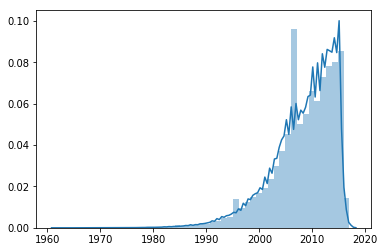

In [16]:
sns.distplot(np.asarray(df_input['Year'].values, dtype=int))

# Train test split

In [17]:
t0 = 1980
t1 = 2015
t_del = 6
t_label = 3

In [18]:
def get_timespan(t0, t1, t_del):
    train_feature = []
    train_label = []
    test_feature = []
    test_label = []
    for ii in range(t0, t1-t_del, t_del):
        train_feature.append((ii, ii+t_del-t_label))
        train_label.append((ii+t_del-t_label,ii+t_del))
    test_feature.append((t1-t_del+1, t1-t_label+1))
    test_label.append((t1-t_label+1, t1+1))
    return train_feature, train_label, test_feature, test_label

In [19]:
train_feature_span, train_label_span, test_feature_span, test_label_span = get_timespan(t0, t1, t_del)

In [20]:
train_feature_span, train_label_span, test_feature_span, test_label_span

([(1980, 1983), (1986, 1989), (1992, 1995), (1998, 2001), (2004, 2007)],
 [(1983, 1986), (1989, 1992), (1995, 1998), (2001, 2004), (2007, 2010)],
 [(2010, 2013)],
 [(2013, 2016)])

In [21]:
year_prev = (t0-t_del, t0-t_label)
info_prev = [jj for jj in info if (jj['year'] >= year_prev[0]) and 
                      (jj['year'] < year_prev[1])]

In [22]:
train_df_feature = []
train_df_label = []
train_info = []

for ii in range(len(train_feature_span)):
    train_df_feature.append(df_input[(df_input['Year'] >= str(train_feature_span[ii][0])) &
                                  (df_input['Year'] < str(train_feature_span[ii][1]))])
    train_df_label.append(df_input[(df_input['Year'] >= str(train_label_span[ii][0])) &
                                  (df_input['Year'] < str(train_label_span[ii][1]))])
    train_info.append([jj for jj in info if (jj['year'] >= train_feature_span[ii][0]) and 
                      (jj['year'] < train_feature_span[ii][1])])


In [23]:
test_df_feature = []
test_df_label = []
test_info = []

test_df_feature.append(df_input[(df_input['Year'] >= str(test_feature_span[0][0])) &
                                  (df_input['Year'] < str(test_feature_span[0][1]))])
test_df_label.append(df_input[(df_input['Year'] >= str(test_label_span[0][0])) &
                                  (df_input['Year'] < str(test_label_span[0][1]))])
test_info.append([jj for jj in info if (jj['year'] >= test_feature_span[0][0]) and 
                      (jj['year'] < test_feature_span[0][1])])

In [24]:
def merge_feature_label(df1, df2):
    return pd.merge(df1.iloc[:, :-1], df2[['Authors', 'Count']], how='left', on=['Authors']).fillna(0.0)

In [25]:
train_df_input = []
test_df_input = []

for ii in range(len(train_df_feature)):
    train_df_input.append(merge_feature_label(train_df_feature[ii], train_df_label[ii]))
test_df_input.append(merge_feature_label(test_df_feature[0], test_df_label[0]))

In [26]:
s = 0
for ii in range(len(train_df_input)):
    s += sum(train_df_input[ii]['Count']==0)/len(train_df_input[ii])
s/len(train_df_input)

0.5681046035813591

In [27]:
sum(test_df_input[0]['Count']==0)/len(test_df_input[0])

0.5343198266721984

In [28]:
len(train_df_input)

5

# Feature Engineer

In [29]:
num = len(train_df_input)

In [30]:
all_info = concat_train_test(train_info, test_info)

In [31]:
df_author_train = [pd.DataFrame() for _ in range(num)]

In [32]:
df_author_test = pd.DataFrame()

### Name

In [33]:
def get_name(info):
    ans = set()
    for ii in info:
        for jj in ii['authors']:
            ans.add(jj)
    return list(ans)

In [34]:
name_train = []
name_test = []
for ii in range(len(train_df_input)):
    name_train.append(get_name(train_info[ii]))
name_test = get_name(test_info[0])

In [35]:
for ii in range(num):
    df_author_train[ii]['name'] = name_train[ii]

In [36]:
df_author_test['name'] = name_test

### Previously Cooperated Count

In [37]:
def get_pre_coop(info, author_list):
    ans = {}
    for ii in author_list:
        ans[ii] = {}
    for ii in info:
        for jj in ii['authors']:
            if jj in ans:
                for kk in ii['authors']:
                    if jj != kk:
                        if kk in ans[jj]:
                            ans[jj][kk] += 1
                        else:
                            ans[jj][kk] = 1
    return ans

In [38]:
# pre_coop_train = []
# pre_coop_train.append(get_pre_coop(info_prev, df_author_train[0]['name']))
# for ii in range(1, num):
#     pre_coop_train.append(get_pre_coop(train_info[ii-1], df_author_train[ii]['name']))

In [39]:
# pre_coop_test = get_pre_coop(train_info[num-1], df_author_test['name'])

### Author Productivity

In [40]:
def get_prod(info, author_list):
    ans = {}
    for ii in author_list:
        ans[ii] = 0
    for ii in info:
        for jj in ii['authors']:
            if jj in ans:
                ans[jj] += 1
    return ans

In [41]:
prod_train = []
for ii in range(num):
    prod_train.append(get_prod(train_info[ii], df_author_train[ii]['name']))

In [42]:
prod_test = get_prod(test_info[0], df_author_test['name'])

In [43]:
for ii in range(num):
    df_author_train[ii]['prod'] = df_author_train[ii]['name'].map(prod_train[ii])

In [44]:
df_author_test['prod'] = df_author_test['name'].map(prod_test)

### H-index

In [45]:
def get_h_index(info, author_list):
    dic = {}
    for ii in author_list:
        dic[ii] = []
    for ii in info:
        for jj in ii['authors']:
            if jj in dic:
                dic[jj].append(ii['n_citation'])
    author_paper_cite_count = {}
    for ii in dic.keys():
        author_paper_cite_count[ii] = sorted(dic[ii], reverse=True)
    author_h_index = cal_h_index(author_paper_cite_count)
    return author_h_index

In [46]:
def cal_h_index(dic):
    ans = {}
    for ii in dic.keys():
        jj = 1
        while jj < len(dic[ii]) and jj <= dic[ii][jj]:
            jj += 1
        ans[ii] = jj - 1
    return ans

In [47]:
h_index_train = []
for ii in range(num):
    h_index_train.append(get_h_index(flatten(train_info, ii), df_author_train[ii]['name']))

In [48]:
h_index_test = get_h_index(all_info, df_author_test['name'])

In [49]:
for ii in range(num):
    df_author_train[ii]['h_index'] = df_author_train[ii]['name'].map(h_index_train[ii])

In [50]:
df_author_test['h_index'] = df_author_test['name'].map(h_index_test)

### Author Diversity

In [51]:
def get_author_diversity(info, author_list):
    ans = {}
    for ii in author_list:
        ans[ii] = []
    for ii in info:
        for jj in ii['authors']:
            if jj in ans:
                ans[jj].extend([tt for tt in ii['authors'] if tt != jj])
    author_diversity = {}
    for ii in ans.keys():
        if len(ans[ii]) == 0:
            author_diversity[ii] = 0
        else:
            author_diversity[ii] = len(set(ans[ii]))/len(ans[ii])
    return author_diversity

In [52]:
author_diversity_train = []
for ii in range(num):
    author_diversity_train.append(get_author_diversity(train_info[ii], df_author_train[ii]['name']))

In [53]:
author_diversity_test = get_author_diversity(test_info[0], df_author_test['name'])

In [54]:
for ii in range(num):
    df_author_train[ii]['diversity'] = df_author_train[ii]['name'].map(author_diversity_train[ii])

In [55]:
df_author_test['diversity'] = df_author_test['name'].map(author_diversity_test)

### Average Team Size

In [56]:
def get_avg_team_size(info, author_list):
    ans = {}
    for ii in author_list:
        ans[ii] = []
    for ii in info:
        for jj in ii['authors']:
            if jj in ans:
                ans[jj].append(len(ii['authors']))
    avg_team_size = {}
    for ii in ans.keys():
        if len(ans[ii]) == 0:
            avg_team_size[ii] = 0
        else:
            avg_team_size[ii] = sum(ans[ii])/len(ans[ii])
    return avg_team_size

In [57]:
avg_team_size_train = []
for ii in range(num):
    avg_team_size_train.append(get_avg_team_size(train_info[ii], df_author_train[ii]['name']))

In [58]:
avg_team_size_test = get_avg_team_size(test_info[0], df_author_test['name'])

In [59]:
for ii in range(num):
    df_author_train[ii]['avg_team_size'] = df_author_train[ii]['name'].map(avg_team_size_train[ii])

In [60]:
df_author_test['avg_team_size'] = df_author_test['name'].map(avg_team_size_test)

### Reference Diversity

In [61]:
def get_ref_diversity(info, author_list):
    ans = {}
    for ii in author_list:
        ans[ii] = []
    for ii in info:
        if 'references' in ii:
            for jj in ii['authors']:
                if jj in ans:
                    ans[jj].extend(ii['references'])
    ref_div = {}
    for ii in ans.keys():
        if len(ans[ii]) == 0:
            ref_div[ii] = 0
        else:
            ref_div[ii] = len(set(ans[ii]))/len(ans[ii])
    return ref_div

In [62]:
ref_div_train = []
for ii in range(num):
    ref_div_train.append(get_ref_diversity(train_info[ii], df_author_train[ii]['name']))

In [63]:
ref_div_test = get_ref_diversity(test_info[0], df_author_test['name'])

In [64]:
for ii in range(num):
    df_author_train[ii]['ref_diversity'] = df_author_train[ii]['name'].map(ref_div_train[ii])

In [65]:
df_author_test['ref_diversity'] = df_author_test['name'].map(ref_div_test)

### Age

In [66]:
def get_age(info, author_list):
    author_age = {}
    for ii in author_list:
        author_age[ii] = [100000, -100]
    for ii in info:
        year = ii['year']
        for jj in ii['authors']:
            if jj in author_age:
                author_age[jj][0] = min(author_age[jj][0], year)
                author_age[jj][1] = max(author_age[jj][1], year)
    for ii in author_age.keys():
        author_age[ii] = author_age[ii][1] - author_age[ii][0]
    return author_age

In [67]:
age_train = []
for ii in range(num):
    age_train.append(get_age(flatten(train_info, ii), df_author_train[ii]['name']))

In [68]:
age_test = get_age(all_info, df_author_test['name'])

In [69]:
for ii in range(num):
    df_author_train[ii]['age'] = df_author_train[ii]['name'].map(age_train[ii])

In [70]:
df_author_test['age'] = df_author_test['name'].map(age_test)

### Trend

In [71]:
def get_trend(info_prev, info_curr, author_list):
    author_trend = {}
    for ii in author_list:
        author_trend[ii] = 0
    prod = {}
    for ii in author_list:
        prod[ii] = [0, 0]
    for ii in info_prev:
        for jj in ii['authors']:
            if jj in prod:
                prod[jj][0] += 1
    for ii in info_curr:
        for jj in ii['authors']:
            if jj in prod:
                prod[jj][1] += 1
    for ii in prod.keys():
        if prod[ii][0] > prod[ii][1]:
            author_trend[ii] = -1
        elif prod[ii][0] < prod[ii][1]:
            author_trend[ii] = 1
        else:
            author_trend[ii] = 0
    return author_trend
        

In [72]:
trend_train = []
trend_train.append(get_trend(info_prev, train_info[0], df_author_train[0]['name']))
for ii in range(1, num):
    trend_train.append(get_trend(train_info[ii-1], train_info[ii], df_author_train[ii]['name']))

In [73]:
trend_test = get_trend(train_info[num-1], test_info[0], df_author_test['name'])

In [74]:
for ii in range(num):
    df_author_train[ii]['trend'] = df_author_train[ii]['name'].map(trend_train[ii])

In [75]:
df_author_test['trend'] = df_author_test['name'].map(trend_test)

### Keywords

In [76]:
def bag_of_word(s):
    temp = re.sub('[^A-Za-z]', ' ', s)
    temp = temp.lower()
    words = word_tokenize(temp)
    ans = []
    for word in words:
        if word not in stopwords.words('english'):
            ans.append(word)
    return " ".join(ans)

In [77]:
def get_one_keyword(data):    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)

    vocab = vectorizer.get_feature_names()

    n_top_words = 5
    k = 1

    model = LatentDirichletAllocation(n_components=k, random_state=100)

    id_topic = model.fit_transform(X)

    topic_words = {}

    for topic, comp in enumerate(model.components_):
        
        word_idx = np.argsort(comp)[::-1][:n_top_words]

        # store the words most relevant to the topic
        topic_words[topic] = [vocab[i] for i in word_idx]

    ans = []
    
    for topic, words in topic_words.items():
#         print('Topic: %d' % topic)
#         print('  %s' % ', '.join(words))
        ans.extend(words)
    return ans

In [78]:
def get_abstracts(info, author_list):
    author_abstract = {}
    for ii in author_list:
        author_abstract[ii] = []
    for ii in info:
        if 'abstract' in ii:
            for jj in ii['authors']:
                if jj in author_abstract:
                    author_abstract[jj].append(ii['abstract'])
    return author_abstract

In [79]:
def get_keywords(info, author_list):
    author_abstract = get_abstracts(info, author_list)
                    
    author_keyword = {}
    cc = 0
    for ii in author_abstract.keys():
        if cc % (len(author_abstract)//100) == 0:
            print(cc//(len(author_abstract)//100))
        cc += 1
        temp = []
        for jj in author_abstract[ii]:
            if jj != '':
                temp.append(jj)
        if temp == []:
            author_keyword[ii] = set()
        else:
            author_keyword[ii] = set()
            try:
                author_keyword[ii].update(get_one_keyword(temp))
            except:
                continue

    for ii in author_keyword.keys():
        author_keyword[ii] = list(author_keyword[ii])

    return author_keyword

In [ ]:
author_keyword_train = []
for ii in range(num):
    author_keyword_train.append(get_keywords(train_info[ii], df_author_train[ii]['name']))

In [ ]:
author_keyword_test = get_keywords(test_info[0], df_author_test['name'])

In [80]:
# with open('train-keywords-0-1980-10.json','w') as fout:
#     for ii in author_keyword_train:
#         fout.write(js.dumps(ii)+'\n')

with open('train-keywords-0-1980-6.json','r') as fin:
    tmp1 = fin.readlines()
    author_keyword_train = []
    for ii in tmp1:
        author_keyword_train.append(js.loads(ii))

In [81]:
# with open('test-keywords-0-1980-10.json','w') as fout:
#     fout.write(js.dumps(author_keyword_test))

with open('test-keywords-0-1980-6.json','r') as fin:
    tmp1 = fin.readline()
    author_keyword_test = js.loads(tmp1)

In [82]:
for ii in range(num):
    df_author_train[ii]['keywords'] = df_author_train[ii]['name'].map(author_keyword_train[ii])

In [83]:
df_author_test['keywords'] = df_author_test['name'].map(author_keyword_test)

### Topic distribution

In [84]:
def get_all_abstract(info):
    author_abstract = []
    for ii in info:
        if 'abstract' in ii:
            author_abstract.append(ii['abstract'])
    return author_abstract

In [85]:
def get_topic_embeddings(info, author_list, topic_num=5):
    author_abstract = get_abstracts(info, author_list)
    all_abstracts = get_all_abstract(info)
    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(all_abstracts)

    lda = LatentDirichletAllocation(n_components=topic_num, random_state=0)
    lda.fit(X)
    
    topic_embeddings = {}
    for ii in author_list:
        if author_abstract[ii] == []:
            topic_embeddings[ii] = [1/topic_num]*topic_num
        else:
            topic_embeddings[ii] = list(np.mean(lda.transform(vectorizer.transform(author_abstract[ii])), axis=0))

    return topic_embeddings

In [ ]:
topic_embeddings_train = []
for ii in range(num):
    topic_embeddings_train.append(get_topic_embeddings(train_info[ii], df_author_train[ii]['name'], 50))

In [ ]:
topic_embeddings_test = get_topic_embeddings(test_info[0], df_author_test['name'], 50)

In [86]:
# with open('train-topics-0-1980-10.json','w') as fout:
#     for ii in topic_embeddings_train:
#         fout.write(js.dumps(ii)+'\n')

with open('train-topics-0-1980-6.json','r') as fin:
    tmp1 = fin.readlines()
    topic_embeddings_train = []
    for ii in tmp1:
        topic_embeddings_train.append(js.loads(ii))

In [87]:
# with open('test-topics-0-1980-10.json','w') as fout:
#     fout.write(js.dumps(topic_embeddings_test))

with open('test-topics-0-1980-6.json','r') as fin:
    tmp1 = fin.readline()
    topic_embeddings_test = js.loads(tmp1)

In [88]:
for ii in range(num):
    df_author_train[ii]['topics'] = df_author_train[ii]['name'].map(topic_embeddings_train[ii])

In [89]:
df_author_test['topics'] = df_author_test['name'].map(topic_embeddings_test)

### Venues

In [90]:
def get_venues(info, author_list):
    ans = {}
    for ii in author_list:
        ans[ii] = set()
    for ii in info:
        for jj in ii['authors']:
            if jj in ans:
                ans[jj].add(ii['venue'])
    for ii in ans.keys():
        ans[ii] = list(ans[ii])
    return ans

In [91]:
author_venue_train = []
for ii in range(num):
    author_venue_train.append(get_venues(flatten(train_info, ii), df_author_train[ii]['name']))

In [92]:
author_venue_test = get_venues(all_info, df_author_test['name'])

In [93]:
for ii in range(num):
    df_author_train[ii]['venue'] = df_author_train[ii]['name'].map(author_venue_train[ii])

In [94]:
df_author_test['venue'] = df_author_test['name'].map(author_venue_test)

### Cooperated authors

In [95]:
def get_cooperated_authors(info, author_list):
    ans = {}
    for ii in author_list:
        ans[ii] = set()
    for ii in info:
        for jj in ii['authors']:
            if jj in ans:
                ans[jj].update([kk for kk in ii['authors'] if kk != jj])
    for ii in ans.keys():
        ans[ii] = list(ans[ii])
    return ans

In [96]:
cooperated_authors_train = []
for ii in range(num):
    cooperated_authors_train.append(get_cooperated_authors(flatten(train_info, ii), df_author_train[ii]['name']))

In [97]:
cooperated_authors_test = get_cooperated_authors(all_info, df_author_test['name'])

In [98]:
for ii in range(num):
    df_author_train[ii]['cooperated_authors'] = df_author_train[ii]['name'].map(cooperated_authors_train[ii])

In [99]:
df_author_test['cooperated_authors'] = df_author_test['name'].map(cooperated_authors_test)

### Author Relationships

In [100]:
all_name = flatten_name(df_author_train, num-1) + list(df_author_test['name'])

In [101]:
info[0]

{'abstract': 'purpose study develop learning tool high school students studying scientific aspects information communication net works specifically focus basic principles network proto cols aim develop learning tool tool gives students hands experience help understand basic principles network protocols',
 'authors': ['Makoto Satoh',
  'Ryo Muramatsu',
  'Mizue Kayama',
  'Kazunori Itoh',
  'Masami Hashimoto',
  'Makoto Otani',
  'Michio Shimizu',
  'Masahiko Sugimoto'],
 'n_citation': 0,
 'references': ['51c7e02e-f5ed-431a-8cf5-f761f266d4be',
  '69b625b9-ebc5-4b60-b385-8a07945f5de9'],
 'title': 'Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map',
 'venue': 'international conference on human-computer interaction',
 'year': 2013,
 'id': '00127ee2-cb05-48ce-bc49-9de556b93346'}

In [102]:
def output_author_pairs(info, author_list, filename):
    author_list_inv = {}
    for ii in range(len(author_list)):
        author_list_inv[author_list[ii]] = ii

    loc = []
    for ii in info:
        for jj in ii['authors']:
            for kk in ii['authors']:
                if jj != kk:
                    loc.append((author_list_inv[jj], author_list_inv[kk]))
    
    with open('graph/'+filename, 'w') as fout:
        for ii in loc:
            fout.write(str(ii[0])+' '+str(ii[1])+'\n')

In [103]:
def get_embeddings(filename, all_list, author_list):    
    embeddings = {}
    for ii in author_list:
        embeddings[ii] = []
    with open('emb/'+filename, 'r') as fin:
        data = fin.readlines()
    for ii in data[1:]:
        temp = [float(jj) for jj in ii.split()]
        name = all_list[int(temp[0])]
        if name in embeddings:
            embeddings[name] = temp[1:]
    return embeddings

In [ ]:
for ii in range(num):
    output_author_pairs(flatten(train_info, ii), flatten_name(df_author_train, ii), 'author_train'+str(ii)+'.edgelist')
    

In [ ]:
output_author_pairs(all_info, all_name, 'author_test.edgelist')

In [ ]:
! python3 node2vec/main.py --input graph/author_train.edgelist --output emb/author_train.emd  --dimensions 64

In [ ]:
! python3 node2vec/main.py --input graph/author_test.edgelist --output emb/author_test.emd  --dimensions 64

In [104]:
embedding_train = []
for ii in range(num):
    embedding_train.append(get_embeddings('author_train'+str(ii)+'.emd', flatten_name(df_author_train, ii), df_author_train[ii]['name']))
    

In [105]:
embedding_test = get_embeddings('author_test.emd', all_name, df_author_test['name'])

In [106]:
for ii in range(num):
    df_author_train[ii]['embeddings'] = df_author_train[ii]['name'].map(embedding_train[ii])

In [107]:
df_author_test['embeddings'] = df_author_test['name'].map(embedding_test)

In [ ]:
# class rel_graph:
#     def __init__(self, info, author_list):
#         self.dist_matrix = {}
#         self.author_list_inv = {}
#         for ii in range(len(author_list)):
#             self.author_list_inv[author_list[ii]] = ii
        
#         loc = []
#         for ii in info:
#             for jj in ii['authors']:
#                 for kk in ii['authors']:
#                     if jj != kk:
#                         loc.append((self.author_list_inv[jj], self.author_list_inv[kk]))
#         val = [1]*len(loc)
#         self.matrix = csr_matrix((val, ([ii[0] for ii in loc], [ii[1] for ii in loc])), 
#                                        shape=(len(loc), len(loc)))
    
#     def cal_distance(self, name1, name2):
#         if name1 in self.dist_matrix:
#             return self.dist_matrix[name1][self.author_list_inv[name2]]
#         dist = shortest_path(csgraph=self.matrix, directed=False, indices=self.author_list_inv[name1])
#         self.dist_matrix[name1] = dist
#         return dist[self.author_list_inv[name2]]

In [ ]:
# train_author_rel = rel_graph(train_info, df_author_train['name'])

# Generate Input and Label (get X and y)

In [108]:
df_author_train_dict = []
for ii in range(num):
    df_author_train_dict.append(df_author_train[ii].set_index('name').to_dict('index'))

In [109]:
df_author_test_dict = df_author_test.set_index('name').to_dict('index')

In [110]:
def combine_duplicate(df_input):
    df_ans = df_input.groupby(df_input.Authors).sum().reset_index()
    author1 = {}
    author2 = {}
    for ii in df_ans.itertuples():
        author = ii[1]
        author1[author] = author.split('和')[0]
        author2[author] = author.split('和')[1]
    df_ans['Author1'] = df_ans['Authors'].map(author1)
    df_ans['Author2'] = df_ans['Authors'].map(author2)
    return df_ans[['Author1', 'Author2', 'Count']]

In [111]:
def cal_intersect(a, b):
    inter = 0
    if len(a) + len(b) == 0:
        return 0
    for ii in a:
        if ii in b:
            inter += 1
    for ii in b:
        if ii in a:
            inter += 1
    return inter/(len(a) + len(b))

In [112]:
def cos(a, b):
    if a == [] or b == []:
        return 0
    else:
        return 1 - cosine(a, b)

In [116]:
def generate_xy(df_input, df_author):
    df_input_new = combine_duplicate(df_input)
    x = {'Author1': [], 'Author2': [], 'Age_avg': [], 'Age_diff': [], 'Trend_avg': [], 'Trend_diff': [],
         'Prod_avg': [], 'Prod_diff': [], 'H_index_avg': [], 'H_index_diff': [],
         'Diversity_avg': [], 'Diversity_diff': [], 'Avg_team_size_avg': [], 'Avg_team_size_diff': [],
         'Ref_diversity_avg': [], 'Ref_diversity_diff': [], 'keyword_overlap': [], 'topics_sim': [],
         'venue_overlap': [], 'coop_overlap': [], 'author_sim': []}
    y = {'Count': []}
    for authors in df_input_new.itertuples():
        y['Count'].append(authors[-1])
        
        author1 = authors[1]
        author2 = authors[2]
        
        author1_info = df_author[author1]
        author2_info = df_author[author2]
        
        x['Author1'].append(author1)
        x['Author2'].append(author2)
        x['Age_avg'].append(0.5*author1_info['age'] + 0.5*author2_info['age'])
        x['Age_diff'].append(abs(author1_info['age'] - author2_info['age']))
        x['Trend_avg'].append(0.5*author1_info['trend'] + 0.5*author2_info['trend'])
        x['Trend_diff'].append(abs(author1_info['trend'] - author2_info['trend']))
        x['Prod_avg'].append(0.5*author1_info['prod'] + 0.5*author2_info['prod'])
        x['Prod_diff'].append(abs(author1_info['prod'] - author2_info['prod']))
        x['H_index_avg'].append(0.5*author1_info['h_index'] + 0.5*author2_info['h_index'])
        x['H_index_diff'].append(abs(author1_info['h_index'] - author2_info['h_index']))
        x['Diversity_avg'].append(0.5*author1_info['diversity'] + 0.5*author2_info['diversity'])
        x['Diversity_diff'].append(abs(author1_info['diversity'] - author2_info['diversity']))
        x['Avg_team_size_avg'].append(0.5*author1_info['avg_team_size'] + 0.5*author2_info['avg_team_size'])
        x['Avg_team_size_diff'].append(abs(author1_info['avg_team_size'] - author2_info['avg_team_size']))
        x['Ref_diversity_avg'].append(0.5*author1_info['ref_diversity'] + 0.5*author2_info['ref_diversity'])
        x['Ref_diversity_diff'].append(abs(author1_info['ref_diversity'] - author2_info['ref_diversity']))
        x['keyword_overlap'].append(cal_intersect(author1_info['keywords'], author2_info['keywords']))
        x['topics_sim'].append(KL(author1_info['topics'], author2_info['topics']))
        x['venue_overlap'].append(cal_intersect(author1_info['venue'], author2_info['venue']))
        x['coop_overlap'].append(cal_intersect(author1_info['cooperated_authors'], author2_info['cooperated_authors']))
        x['author_sim'].append(cos(author1_info['embeddings'], author2_info['embeddings']))
#         x['pre_coop'].append(pre_coop[author1][author2] if author2 in pre_coop[author1] else 0)
    
    return pd.DataFrame(x, columns=['Author1', 'Author2', 'Age_avg', 'Age_diff', 'Trend_avg', 'Trend_diff',
                                    'Prod_avg', 'Prod_diff', 'H_index_avg', 'H_index_diff', 
                                   'Diversity_avg', 'Diversity_diff', 'Avg_team_size_avg', 'Avg_team_size_diff', 
                                    'Ref_diversity_avg', 'Ref_diversity_diff', 'keyword_overlap',
                                   'topics_sim', 'venue_overlap', 'coop_overlap', 'author_sim']), pd.DataFrame(y, columns=['Count'])

In [117]:
xy_train = [generate_xy(train_df_input[ii], df_author_train_dict[ii]) for ii in range(num)]

In [118]:
x_train = pd.concat([ii[0] for ii in xy_train], axis=0)

In [119]:
y_train = pd.concat([ii[1] for ii in xy_train], axis=0)

In [120]:
x_test, y_test = generate_xy(test_df_input[0], df_author_test_dict)

In [ ]:
# comment out for regression

# y_train['Count'] = np.asarray((y_train != 0), dtype=np.float)
# y_test['Count'] = np.asarray((y_test != 0), dtype=np.float)

In [ ]:
# save_df(x_train, 'x'+'_'+'ref0'+'_'+str(t0)+'_'+str(t_del)+'.csv', 'csv')
# save_df(y_train, 'y'+'_'+'ref0'+'_'+str(t0)+'_'+str(t_del)+'.csv', 'csv')

In [ ]:
# x_train = load_df('x_ref0_2014_10.csv', 'csv')

In [ ]:
# y_train = load_df('y_ref0_2014_10.csv', 'csv')

In [121]:
y_test.describe()

,Count
count,144497.000000
mean,1.109213
std,3.140796
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,129.000000


In [122]:
x_train

,Author1,Author2,Age_avg,Age_diff,Trend_avg,Trend_diff,Prod_avg,Prod_diff,H_index_avg,H_index_diff,...,Diversity_diff,Avg_team_size_avg,Avg_team_size_diff,Ref_diversity_avg,Ref_diversity_diff,keyword_overlap,topics_sim,venue_overlap,coop_overlap,author_sim
0,Abraham Lempel,Gadiel Seroussi,0.0,0,1.0,0,2.0,2,1.0,2,...,0.000000,2.833333,0.333333,1.000000,0.000000,1.0,0.000000,0.666667,0.285714,0.635253
1,Abraham Lempel,Jacob Ziv,1.0,2,1.0,0,2.5,1,1.5,1,...,0.000000,2.333333,0.666667,1.000000,0.000000,0.4,0.211164,0.666667,0.285714,0.602456
2,Abraham Lempel,Oded Goldreich,0.0,0,1.0,0,2.5,1,1.5,1,...,0.333333,2.583333,0.166667,0.500000,1.000000,0.0,2.723456,0.666667,0.285714,0.000000
3,Abraham Lempel,Shimon Even,1.0,2,1.0,0,5.0,4,3.5,3,...,0.250000,2.404762,0.523810,0.888889,0.222222,0.0,1.834163,0.285714,0.181818,0.608558
4,Akifumi Makinouchi,Hajime Kitakami,0.0,0,1.0,0,1.0,0,0.0,0,...,0.000000,4.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.666667,0.396295
5,Akifumi Makinouchi,Susumu Adachi,0.0,0,1.0,0,1.0,0,0.0,0,...,0.000000,4.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.666667,0.409041
6,Akira Fusaoka,Tadashi Kanamori,0.0,0,1.0,0,1.0,0,0.0,0,...,0.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.500000,0.602751
7,Akira Maruoka,Masayuki Kimura,0.0,0,-0.5,1,1.0,0,0.0,0,...,0.000000,2.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000
8,Akira Nakamura,Hiroakira Ono,1.0,2,1.0,0,2.0,2,0.0,0,...,0.000000,2.166667,0.333333,0.500000,1.000000,0.0,2.168293,0.500000,0.000000,0.000000
9,Akira Nakamura,Itsuo Takanami,2.0,0,1.0,0,4.0,2,1.5,3,...,0.625000,2.466667,0.266667,0.840000,0.320000,0.0,2.492987,0.333333,0.285714,0.394565


# Baseline 1 (guess 1)

In [123]:
# regression
np.sqrt(mean_squared_error([1 for ii in range(len(y_test))], y_test))

3.142683742122118

In [124]:
# classification
# accuracy_score([0 for ii in range(len(y_test))], y_test)

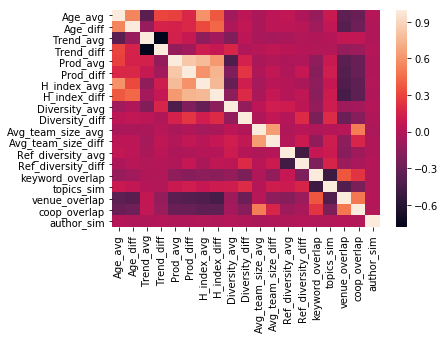

In [125]:
corr_x = x_train.iloc[:, 2:].corr()
sns.heatmap(corr_x, 
        xticklabels=corr_x.columns,
        yticklabels=corr_x.columns)

# Feature Selection (mutual info)

In [126]:
sk = SelectKBest(mutual_info_regression)
sk.fit(x_train.iloc[0:20000, 2:], y_train.values.ravel()[0:20000])

SelectKBest(k=10,
      score_func=<function mutual_info_regression at 0x1a1ec8b400>)

In [127]:
kbest_ans = list(zip(list(range(len(sk.scores_))), sk.scores_))
k_best_ans_sort = sorted(kbest_ans, key=lambda x: x[1], reverse=True)
ans_name = [(x_train.iloc[:, 2:].columns[ii[0]], ii[1]) for ii in k_best_ans_sort]

In [128]:
ans_name

[('Diversity_avg', 0.06644118803959209),
 ('Diversity_diff', 0.023998893161089718),
 ('Age_avg', 0.0227981129598831),
 ('topics_sim', 0.021385332928543832),
 ('Ref_diversity_avg', 0.01973718541529834),
 ('Prod_avg', 0.018489591356134483),
 ('Avg_team_size_diff', 0.017499523796696614),
 ('venue_overlap', 0.017472332751789388),
 ('Ref_diversity_diff', 0.014792530228941558),
 ('Avg_team_size_avg', 0.012212444874101003),
 ('coop_overlap', 0.011878861748543912),
 ('H_index_avg', 0.010658280959668254),
 ('author_sim', 0.0056652629430065105),
 ('Prod_diff', 0.004750740564853473),
 ('Age_diff', 0.004162720198689129),
 ('Trend_diff', 0.002017352684904772),
 ('Trend_avg', 0.0),
 ('H_index_diff', 0.0),
 ('keyword_overlap', 0.0)]

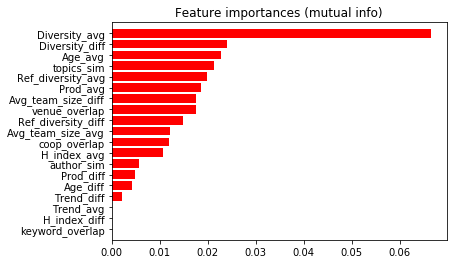

In [129]:
plt.figure()
plt.title("Feature importances (mutual info)")
plt.barh(range(len(ans_name)), [ii[1] for ii in ans_name[::-1]],
       color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(len(ans_name)), [ii[0] for ii in ans_name[::-1]])
plt.ylim([-1, len(ans_name)])
plt.show()

In [130]:
del sk

# Model 1 (RF)

In [131]:
rf = RandomForestRegressor()
# rf = RandomForestClassifier()
rf.fit(x_train.iloc[:, 2:], y_train.values.ravel())

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

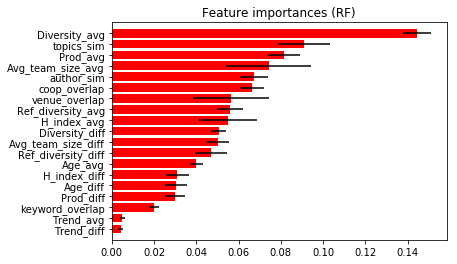

In [132]:
rf_importance = [(list(x_train.iloc[:, 2:].columns)[ii], rf.feature_importances_[ii]) for ii in np.argsort(rf.feature_importances_)[::-1]]
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances (RF)")
plt.barh(range(len(importances)), importances[indices],
       color="r", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(len(importances)), [ii[0] for ii in rf_importance[::-1]])
plt.ylim([-1, len(importances)])
plt.show()

In [133]:
y_pred_rf = rf.predict(x_test.iloc[:, 2:])

In [134]:
# regression
np.sqrt(mean_squared_error(y_pred_rf, y_test))

2.926889845365403

In [135]:
# classification
# accuracy_score(y_pred_rf, y_test)

# Model 2 (LightGBM)

In [136]:
d_train = lgb.Dataset(x_train.iloc[:, 2:], label=y_train.values.ravel())

In [137]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 

    'learning_rate': 0.1, 
    'num_leaves': 50, 
    'max_depth': 6,

    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    }

### parameters tuning

In [ ]:
cv_results = lgb.cv(
    params, d_train, num_boost_round=1000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])

In [ ]:
from sklearn.model_selection import GridSearchCV

model_lgb = lgb.LGBMRegressor(objective='regression',
                              learning_rate=0.1, n_estimators=221,
                              metric='rmse', bagging_fraction = 0.8,feature_fraction = 0.8)

params_test1={
    'max_depth': range(3,8,2),
    'num_leaves':range(2, 11, 3)
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)


In [ ]:
gsearch1.best_params_

In [ ]:
gsearch1.fit(x_train.iloc[:, 2:], y_train.values.ravel())

In [ ]:
gsearch1.best_params_

In [ ]:
np.sqrt(-gsearch1.best_score_)

In [ ]:
params_test2={
    'max_depth': [6,7,8],
    'num_leaves':[9,10,11,12,13,14,15]
}

gsearch2 = GridSearchCV(estimator=model_lgb, param_grid=params_test2, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch2.fit(x_train.iloc[:, 2:], y_train.values.ravel())
gsearch2.best_params_, np.sqrt(-gsearch2.best_score_)


In [ ]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 

    'learning_rate': 0.005, 
    'num_leaves': 50, 
    'max_depth': 6,

    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    }

cv_results = lgb.cv(
    params, d_train, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=100, show_stdv=True)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])

In [138]:
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 

    'learning_rate': 0.005, 
    'num_leaves': 50, 
    'max_depth': 6,
    'n_estimators': 4173,
    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    }

In [139]:
lgbr = lgb.train(params, d_train)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [140]:
p_test = lgbr.predict(x_test.iloc[:, 2:])

In [141]:
# regression
np.sqrt(mean_squared_error(p_test, y_test))

2.776748453056465

In [142]:
# classification
# accuracy_score(p_test, y_test)

# Model 3 (Linear regression)

In [143]:
lr = linear_model.Lasso(alpha=0.1)
lr.fit(x_train.iloc[:, 2:], y_train.values.ravel())

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [144]:
lr.coef_

array([-0.00314373,  0.01622088,  0.        , -0.        ,  0.12921749,
       -0.05086654,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.06680443, -0.        , -0.        ,  0.        ,
       -0.29056411,  0.        ,  0.        , -0.        ])

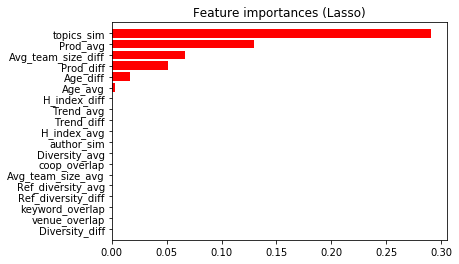

In [145]:
lr_coef = [abs(ii) for ii in lr.coef_]
lr_importance = [(list(x_train.iloc[:, 2:].columns)[ii], lr_coef[ii]) for ii in np.argsort(lr_coef)[::-1]]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances (Lasso)")
plt.barh(range(len(lr_importance)), [ii[1] for ii in lr_importance[::-1]],
       color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(len(lr_importance)), [ii[0] for ii in lr_importance[::-1]])
plt.ylim([-1, len(lr_importance)])
plt.show()

In [146]:
y_pred_lr = lr.predict(x_test.iloc[:, 2:])

In [147]:
np.sqrt(mean_squared_error(y_pred_lr, y_test))

3.1075427531119875